In [100]:
!jupyter nbconvert --to markdown 9_2_7_Exercises.ipynb

[NbConvertApp] WARNING | Config option `kernel_spec_manager_class` not recognized by `NbConvertApp`.
[NbConvertApp] Converting notebook 9_1_6_Exercises.ipynb to markdown
[NbConvertApp] Support files will be in 9_1_6_Exercises_files/
[NbConvertApp] Writing 16918 bytes to 9_1_6_Exercises.md


In [22]:
import sys
import torch.nn as nn
import torch
import warnings
sys.path.append('/home/jovyan/work/d2l_solutions/notebooks/exercises/d2l_utils/')
import d2l
from torchsummary import summary
warnings.filterwarnings("ignore")

class Data(d2l.DataModule):
    def __init__(self, batch_size=16, T=1000, num_train=600, tau=4, randn=0.2):
        self.save_hyperparameters()
        self.time = torch.range(1, T, dtype=torch.float32)
        self.x = torch.sin(0.01*self.time) + torch.randn(T)*randn
        
    def get_dataloader(self, train):
        features = [self.x[i:self.T-self.tau+i] for i in range(self.tau)]
        self.features = torch.stack(features, 1)
        self.labels = self.x[self.tau:].reshape((-1, 1))
        i = slice(0, self.num_train) if train else slice(self.num_train, None)
        return self.get_tensorloader([self.features, self.labels], train, i)
    
class TauData(d2l.DataModule):
    def __init__(self, x, batch_size=16, T=1000, num_train=600, tau=4):
        self.save_hyperparameters()
        self.time = torch.range(1, T, dtype=torch.float32)
        
    def get_dataloader(self, train):
        features = [self.x[i:self.T-self.tau+i] for i in range(self.tau)]
        self.features = torch.stack(features, 1)
        self.labels = self.x[self.tau:].reshape((-1, 1))
        i = slice(0, self.num_train) if train else slice(self.num_train, None)
        return self.get_tensorloader([self.features, self.labels], train, i)

# 1. Improve the model in the experiment of this section.

## 1.1 Incorporate more than the past four observations? How many do you really need?

past **64** observations will be enough.

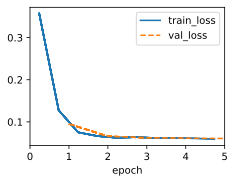

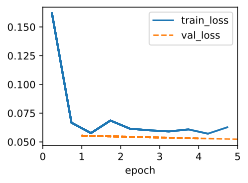

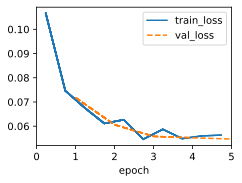

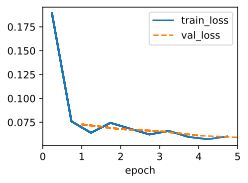

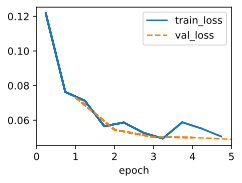

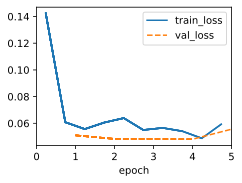

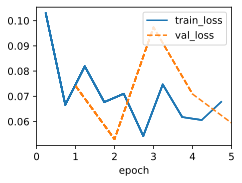

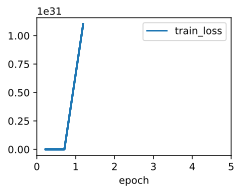

In [19]:
org_data = Data()
taus = [4, 8, 16, 32, 64, 128, 256, 512]
tau_loss = []
for t in taus:
    data = TauData(x=org_data.x, tau=t)
    model = d2l.LinearRegression(lr=0.01)
    trainer = d2l.Trainer(max_epochs=5)
    trainer.fit(model, data)
    onestep_preds = model(data.features[data.num_train:])
    tau_loss.append(model.loss(y_hat=onestep_preds, y=data.labels[data.num_train:]).item())

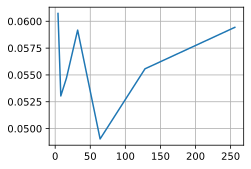

In [20]:
d2l.plot(taus, tau_loss)

## 1.2 How many past observations would you need if there was no noise? Hint: you can write $\sin$ and $\cos$ as a differential equation.



past 8/64 observations will be enough.

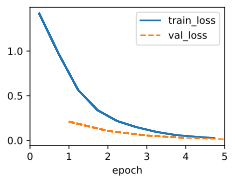

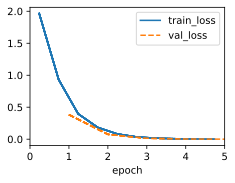

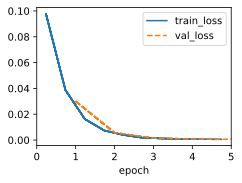

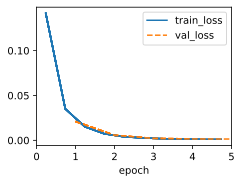

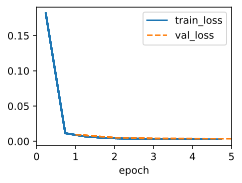

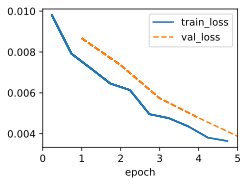

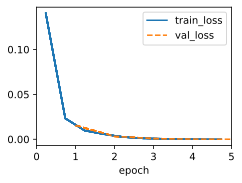

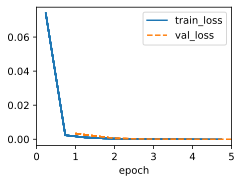

In [36]:
org_data = Data(randn=0)
taus = [1, 2, 4, 8, 16, 32, 64, 128]
tau_loss = []
for t in taus:
    data = TauData(x=org_data.x, tau=t)
    model = d2l.LinearRegression(lr=0.01)
    trainer = d2l.Trainer(max_epochs=5)
    trainer.fit(model, data)
    onestep_preds = model(data.features[data.num_train:])
    tau_loss.append(model.loss(y_hat=onestep_preds, y=data.labels[data.num_train:]).item())

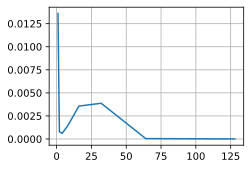

In [37]:
d2l.plot(taus, tau_loss)

## 1.3 Can you incorporate older observations while keeping the total number of features constant? Does this improve accuracy? Why?

We can use weighted average of older observations while keeping the total number of features constant, while this does not improve accuracy, because the weighted average might lose some information.

In [61]:
class CorOldData(d2l.DataModule):
    def __init__(self, x, batch_size=16, T=1000, num_train=600, tau=4, randn=0.2):
        self.save_hyperparameters()
        self.time = torch.range(1, T, dtype=torch.float32)
        self.x = x
        
    def get_dataloader(self, train):
        features = [self.x[i:self.T-self.tau+i] for i in range(self.tau+1)]
        features = torch.stack(features, 1)
        features[:, -2] = (features[:, -2]+features[:, -1])/2
        self.features = features[:, :-1]
        self.labels = self.x[self.tau:].reshape((-1, 1))
        # print(self.features.shape,self.labels.shape)
        i = slice(0, self.num_train) if train else slice(self.num_train, None)
        return self.get_tensorloader([self.features, self.labels], train, i)

0.00035995926009491086

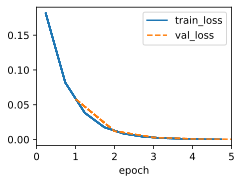

In [62]:
org_data = Data(randn=0)
model = d2l.LinearRegression(lr=0.01)
trainer = d2l.Trainer(max_epochs=5)
trainer.fit(model, org_data)
onestep_preds = model(org_data.features[org_data.num_train:])
model.loss(y_hat=onestep_preds, y=data.labels[org_data.num_train:]).item()

0.000580643187277019

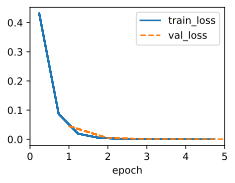

In [63]:
data = CorOldData(x=org_data.x)
model = d2l.LinearRegression(lr=0.01)
trainer = d2l.Trainer(max_epochs=5)
trainer.fit(model, data)
onestep_preds = model(data.features[data.num_train:])
model.loss(y_hat=onestep_preds, y=data.labels[data.num_train:]).item()

## 1.4 Change the neural network architecture and evaluate the performance. You may train the new model with more epochs. What do you observe?

In [92]:
class MulMLPReg(d2l.LinearRegression):
    def __init__(self, num_outputs, num_hiddens, lr):
        super().__init__(lr)
        self.save_hyperparameters()
        layers = [nn.Flatten()]
        for num in num_hiddens:
            layers.append(nn.Sequential(nn.LazyLinear(num),
                                        nn.ReLU(),
                                        # nn.LazyBatchNorm1d()
                                       ))
        layers.append(nn.LazyLinear(num_outputs))
        self.net = nn.Sequential(*layers)
        
    def forward(self, X):
        X = self.net[0](X)
        for blk in self.net[1:-1]:
            Y = blk(X)
            # Concatenate input and output of each block along the channels
            X = torch.cat((X, Y), dim=1)
            
        return self.net[-1](X)

0.00021230550191830844

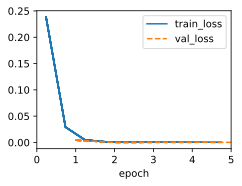

In [97]:
model = MulMLPReg(lr=0.01,num_outputs=1, num_hiddens=[1]*4)
trainer = d2l.Trainer(max_epochs=5)
trainer.fit(model, data)
onestep_preds = model(data.features[data.num_train:])
model.loss(y_hat=onestep_preds, y=data.labels[data.num_train:]).item()

# 2. An investor wants to find a good security to buy. They look at past returns to decide which one is likely to do well. What could possibly go wrong with this strategy?

Relying solely on past returns to make investment decisions, also known as a "chasing performance" strategy, can have several pitfalls and risks:

1. **Mean Reversion**: Markets often exhibit mean reversion, which means that assets that have performed exceptionally well in the past may revert to their historical mean or underperform in the future. Conversely, assets that have performed poorly may rebound.

2. **Overfitting**: Selecting securities based solely on their past performance can lead to overfitting. A security that has recently done well may have simply experienced a temporary anomaly or luck, and such patterns may not persist.

3. **Neglecting Fundamentals**: Relying solely on past returns overlooks fundamental analysis, which considers factors such as a company's financial health, management quality, competitive position, and growth prospects. Neglecting these fundamentals can lead to investing in overvalued or fundamentally weak securities.

4. **Risk-Return Trade-off**: Past returns do not account for the risk associated with an investment. A security that has high past returns may also have higher volatility and downside risk. Ignoring risk can result in unexpected losses.

5. **Herd Behavior**: Following past performance can lead to herd behavior, where many investors pile into the same securities, driving up prices. When the trend reverses, there can be a rush to sell, causing sharp declines.

6. **Market Efficiency**: The Efficient Market Hypothesis suggests that asset prices already reflect all available information, including past performance. If this hypothesis holds, it would be difficult to consistently outperform the market by selecting securities based on historical returns alone.

7. **Transaction Costs**: Frequent buying and selling of securities based on past performance can lead to high transaction costs, which can eat into returns.

8. **Tax Implications**: Frequent trading can have tax implications, as capital gains may be subject to taxation. This can reduce the net returns on investments.

9. **Performance Chasing**: Investors who chase past performance often buy high and sell low. They may buy securities after they have already appreciated significantly and sell in panic during market downturns, which can erode wealth.

10. **Diversification**: Relying solely on past returns may lead to an undiversified portfolio. A well-diversified portfolio can help spread risk and reduce the impact of poor-performing securities.

To make informed investment decisions, it's important to consider a holistic approach that includes fundamental analysis, risk assessment, portfolio diversification, and a long-term investment strategy. Past performance can be one of many factors to consider but should not be the sole basis for investment decisions. Seeking advice from financial professionals and conducting thorough research is essential to develop a well-rounded investment strategy.

# 3. Does causality also apply to text? To which extent?

Causality, in the context of causation or cause-and-effect relationships, does indeed apply to text, but it operates differently than in empirical sciences. Text can convey causal relationships, describe events in a cause-and-effect manner, and be used to infer causal connections, but it does not possess causal agency itself. Here's how causality applies to text:

1. **Describing Causality**: Text can be used to describe causal relationships between events, actions, or phenomena. For example, a news article might describe how a rise in interest rates caused a decrease in consumer spending.

2. **Narrative Structure**: Many forms of storytelling, whether in literature, journalism, or history, rely on causality to structure their narratives. Events are often presented in a cause-and-effect sequence to make stories coherent and engaging.

3. **Causal Language**: Text often contains linguistic markers that indicate causality. Words and phrases like "because," "since," "as a result," "therefore," and "due to" are used to explicitly signal cause-and-effect relationships.

4. **Causal Inference**: Readers of text may use information presented to infer causal relationships even when they are not explicitly stated. For example, if an article mentions that a company's profits plummeted after a major product recall, readers may infer a causal link between the recall and the financial loss.

5. **Causal Discovery**: In text analysis and natural language processing (NLP), researchers and algorithms attempt to discover causal relationships within large bodies of text. This can involve identifying patterns or correlations that suggest causal connections.

However, it's important to note that text-based causality has limitations:

1. **Indirectness**: Textual descriptions of causality are often indirect and may not capture the full complexity of real-world causal relationships. Text may simplify or omit details.

2. **Subjectivity**: The interpretation of causality in text can be subjective and context-dependent. Different readers may perceive different causal links in the same text.

3. **Correlation vs. Causation**: Text may describe correlations or associations, but causation requires more rigorous evidence and analysis. Correlation does not necessarily imply causation, and text can sometimes conflate the two.

4. **Ambiguity**: Natural language is inherently ambiguous, and textual descriptions of causality can be ambiguous as well. Context is critical for disambiguating causal claims.

In summary, causality does apply to text, but text-based causality operates within the realm of language and human interpretation. While text can describe, suggest, and imply causality, it does not possess causal agency itself. Causal claims made in text should be critically evaluated, and rigorous analysis is often required to establish causal relationships beyond textual descriptions.

# 4. Give an example for when a latent autoregressive model might be needed to capture the dynamic of the data.

A latent autoregressive model (LAR) might be needed to capture the dynamics of data when the underlying causal relationships and dependencies between variables are not directly observable or are hidden. This often occurs in situations where the observed data is a result of complex, unobservable processes. Here's an example:

**Example: Stock Market Analysis**

Consider the task of modeling and predicting stock market prices. In this domain, we have daily stock price data, which is observed and readily available. However, the dynamics of stock prices are influenced by a multitude of hidden or latent factors that are not directly observable. These factors can include:

1. **Market Sentiment**: Public sentiment and news sentiment play a crucial role in stock price movements. These sentiments are not directly measured but can have a substantial impact on prices.

2. **Economic Indicators**: Macroeconomic factors like GDP growth, inflation, and interest rates affect the overall market. These indicators are observable but may not be directly related to specific stocks.

3. **Company Performance**: The financial health and performance of a company can influence its stock price. This information is often reported quarterly, making it temporally misaligned with daily price data.

4. **Technical Analysis Indicators**: Traders often use technical indicators like moving averages and trading volumes to make decisions. These indicators are not the same as raw price data and are derived from it.

To model and predict stock prices accurately, a latent autoregressive model can be used. Here's how it might work:

1. **Latent Variables**: The model assumes the existence of latent variables that capture the unobservable factors influencing stock prices. These latent variables represent things like market sentiment, economic conditions, and company performance.

2. **AR Process**: The observed stock prices are modeled as an autoregressive (AR) process, where the current price depends on past prices and the latent variables. The AR process captures the inherent time dependencies in stock prices.

3. **Latent-Variable Estimation**: The challenge is to estimate the values of the latent variables at each time step. This estimation can be done using techniques like Bayesian inference, where observed data and prior knowledge are combined to infer the latent variables.

4. **Prediction**: With the estimated latent variables and the AR process, the model can make predictions about future stock prices that take into account both the historical price data and the unobservable factors.

In this example, the latent autoregressive model is needed because the dynamics of stock prices are influenced by hidden or latent variables that are critical for accurate predictions. Traditional autoregressive models that rely solely on past price data may not capture the full complexity of the stock market dynamics.

Such models are used in finance and economics to understand and predict various phenomena, including stock prices, economic indicators, and consumer behavior, where latent factors play a significant role.